### Imports

In [1]:
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) 
from tensorflow.keras.layers import (
    BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten,
    GaussianNoise, Input, MaxPooling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

2

### Load data

In [3]:
# directory of the dataset
DATA_DIR = '/kaggle/input/resisc20/NWPU-RESISC20' 

# size of the image (images will be resized to these sizes)
img_height = 128
img_width = 128

# size of the batch
batch_size = 32

In [4]:
# loading images and labels from directory
data = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14000 files belonging to 20 classes.


In [5]:
# class names
class_names = data.class_names
num_classes = len(class_names)

In [6]:
import json
class_label_mapping = {index: label for index, label in enumerate(class_names)}

# Zapis do pliku JSON
output_file_path = 'class_labels.json'

with open(output_file_path, 'w') as json_file:
    json.dump(class_label_mapping, json_file, indent=4)

print(f"Saved to: {output_file_path}")

Saved to: class_labels.json


In [7]:
def split_dataset(data,batch_size):
    # Dataset split
    train_size = int(len(data) *.7)
    val_size = int(len(data) *.15) + 1
    test_size = int(len(data) *.15) + 1

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size).take(test_size)

    print(f'Size of the training set: {len(train) * batch_size} ({round(len(train) * batch_size / (len(data) * batch_size), 1) * 100}%)')
    print(f'Size of the validation set: {len(val) * batch_size} ({round(len(val) * batch_size / (len(data) * batch_size), 2) * 100}%)')
    print(f'Size of the testing set: {len(test) * batch_size} ({round(len(test) * batch_size / (len(data) * batch_size), 2) * 100}%)')

    return train, val, test

In [8]:
train, val, test = split_dataset(data,batch_size)

Size of the training set: 9792 (70.0%)
Size of the validation set: 2112 (15.0%)
Size of the testing set: 2112 (15.0%)


In [9]:
for image_batch, labels_batch in train:
    image_shape = image_batch.shape
    print(f"Image batch shape: {image_shape}")
    print(f"Label batch shape: {labels_batch.shape}")
    break

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)


### Plotting dataset

In [10]:
def plot_images(n_rows=3, n_cols=4, data=train):
    plt.figure(figsize=(n_cols*3, int(n_rows*3)))
    for images, labels in data.take(int((n_rows * n_cols) / batch_size) + 1): 
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint16"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

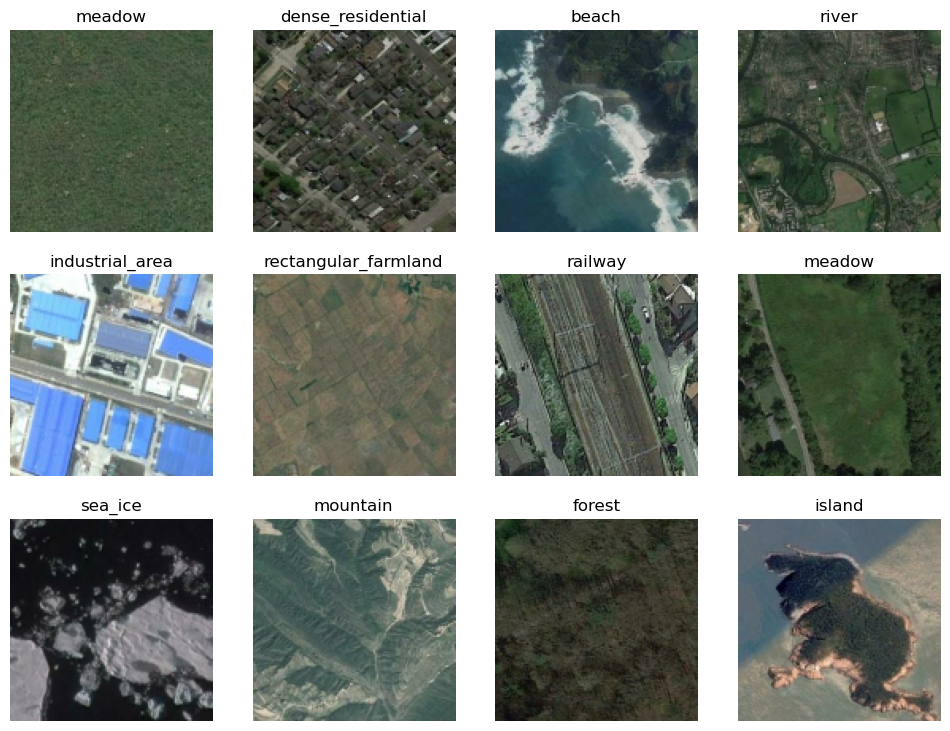

In [11]:
plot_images()

### Model

#### Layers

In [12]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)
input_layer = Input(shape=(img_width, img_height, 3))
gaussian_noise = GaussianNoise(0.25)

In [13]:
model = Sequential()
model.add(input_layer)
model.add(gaussian_noise)
model.add(normalization_layer)

model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(1024, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

In [14]:
model.build(input_shape=image_shape)

In [15]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Callbacks

In [16]:
early_stopping= EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6)

## Training

In [18]:
epochs = 25
model.fit(
  train,
  epochs = epochs,
  validation_data = val,
  batch_size = batch_size,
  callbacks = [early_stopping, reduce_lr],
  verbose = 1
)

Epoch 1/25
306/306 [==============================] - 41s 106ms/step - loss: 1.8843 - accuracy: 0.4752 - val_loss: 5.2779 - val_accuracy: 0.0682 - lr: 1.0000e-04
Epoch 2/25
306/306 [==============================] - 23s 74ms/step - loss: 1.1744 - accuracy: 0.6286 - val_loss: 1.3287 - val_accuracy: 0.5971 - lr: 1.0000e-04
Epoch 3/25
306/306 [==============================] - 24s 77ms/step - loss: 0.9307 - accuracy: 0.7025 - val_loss: 0.8740 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 4/25
306/306 [==============================] - 23s 73ms/step - loss: 0.7597 - accuracy: 0.7560 - val_loss: 0.7469 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 5/25
306/306 [==============================] - 38s 123ms/step - loss: 0.6362 - accuracy: 0.7924 - val_loss: 0.6420 - val_accuracy: 0.7973 - lr: 1.0000e-04
Epoch 6/25
306/306 [==============================] - 37s 121ms/step - loss: 0.5425 - accuracy: 0.8242 - val_loss: 0.8573 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 7/25
306/306 [===========

In [19]:
history = model.history

#### Training process

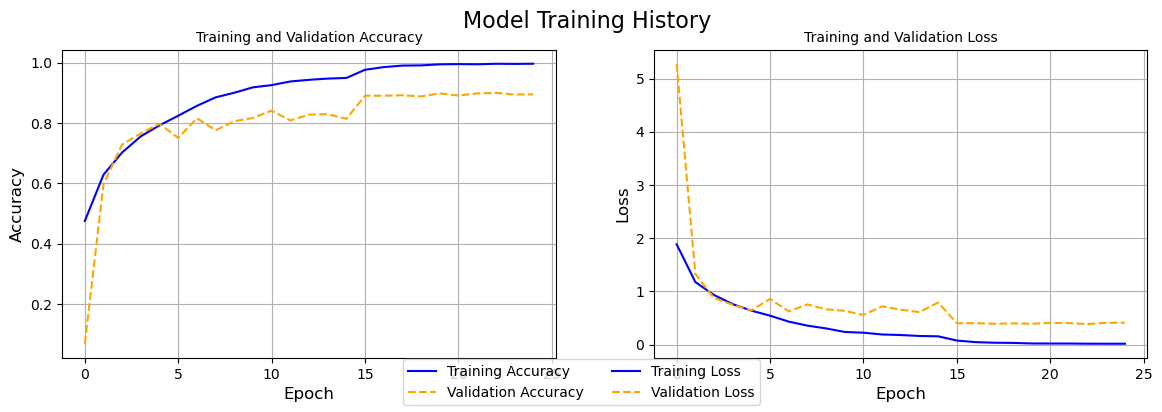

In [20]:
# extract metrics from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# plot accuracy metrics
ax1.plot(acc, label='Training Accuracy', color='blue', linestyle='solid')
ax1.plot(val_acc, label='Validation Accuracy', color='orange', linestyle='dashed')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training and Validation Accuracy', fontsize=10)
ax1.grid()

# plot loss metrics
ax2.plot(loss, label='Training Loss', color='blue', linestyle='solid')
ax2.plot(val_loss, label='Validation Loss', color='orange', linestyle='dashed')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training and Validation Loss', fontsize=10)
ax2.grid()

# add legend and title to figure
fig.legend(loc='lower center', ncol=2, fontsize=10)
fig.suptitle('Model Training History', fontsize=16)

# show the plot
plt.show()

#### Model score on test set

In [21]:
# evaluate the model on the validation dataset
loss, accuracy = model.evaluate(test)

# calculate the number of misclassified images
num_misclassified = int((1 - accuracy) * len(test) * batch_size)

# print the results
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Number of misclassified images: {num_misclassified} of {len(test) * batch_size}")

66/66 [==============================] - 13s 66ms/step - loss: 0.4095 - accuracy: 0.8955
Test loss: 0.4095
Test accuracy: 89.55%
Number of misclassified images: 220 of 2112


In [22]:
# initialize empty lists to store images and labels
test_images = []
test_labels = []

# iterate through the test dataset and append each batch to a list
for batch in test.as_numpy_iterator():
    test_images.append(batch[0])
    test_labels.append(batch[1])

# concatenate the batches into a single array for both images and labels
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

y_true = np.array(test_labels)

In [23]:
# use the trained model to predict the labels for the test images
y_pred = model.predict(test_images)

# convert the predicted probabilities to class labels
y_all_pred = y_pred

y_pred = tf.argmax(y_pred, axis=1).numpy()

66/66 [==============================] - 1s 13ms/step


In [24]:
# get the indices of the incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# get the incorrectly classified images and labels
false_class = list(zip(test_images[incorrect_indices], y_pred[incorrect_indices], y_true[incorrect_indices]))

# get the correctly classified images and labels
correct_indices = np.nonzero(y_pred == y_true)[0]
true_class = list(zip(test_images[correct_indices], y_pred[correct_indices], y_true[correct_indices]))

#### Confusion Matrix

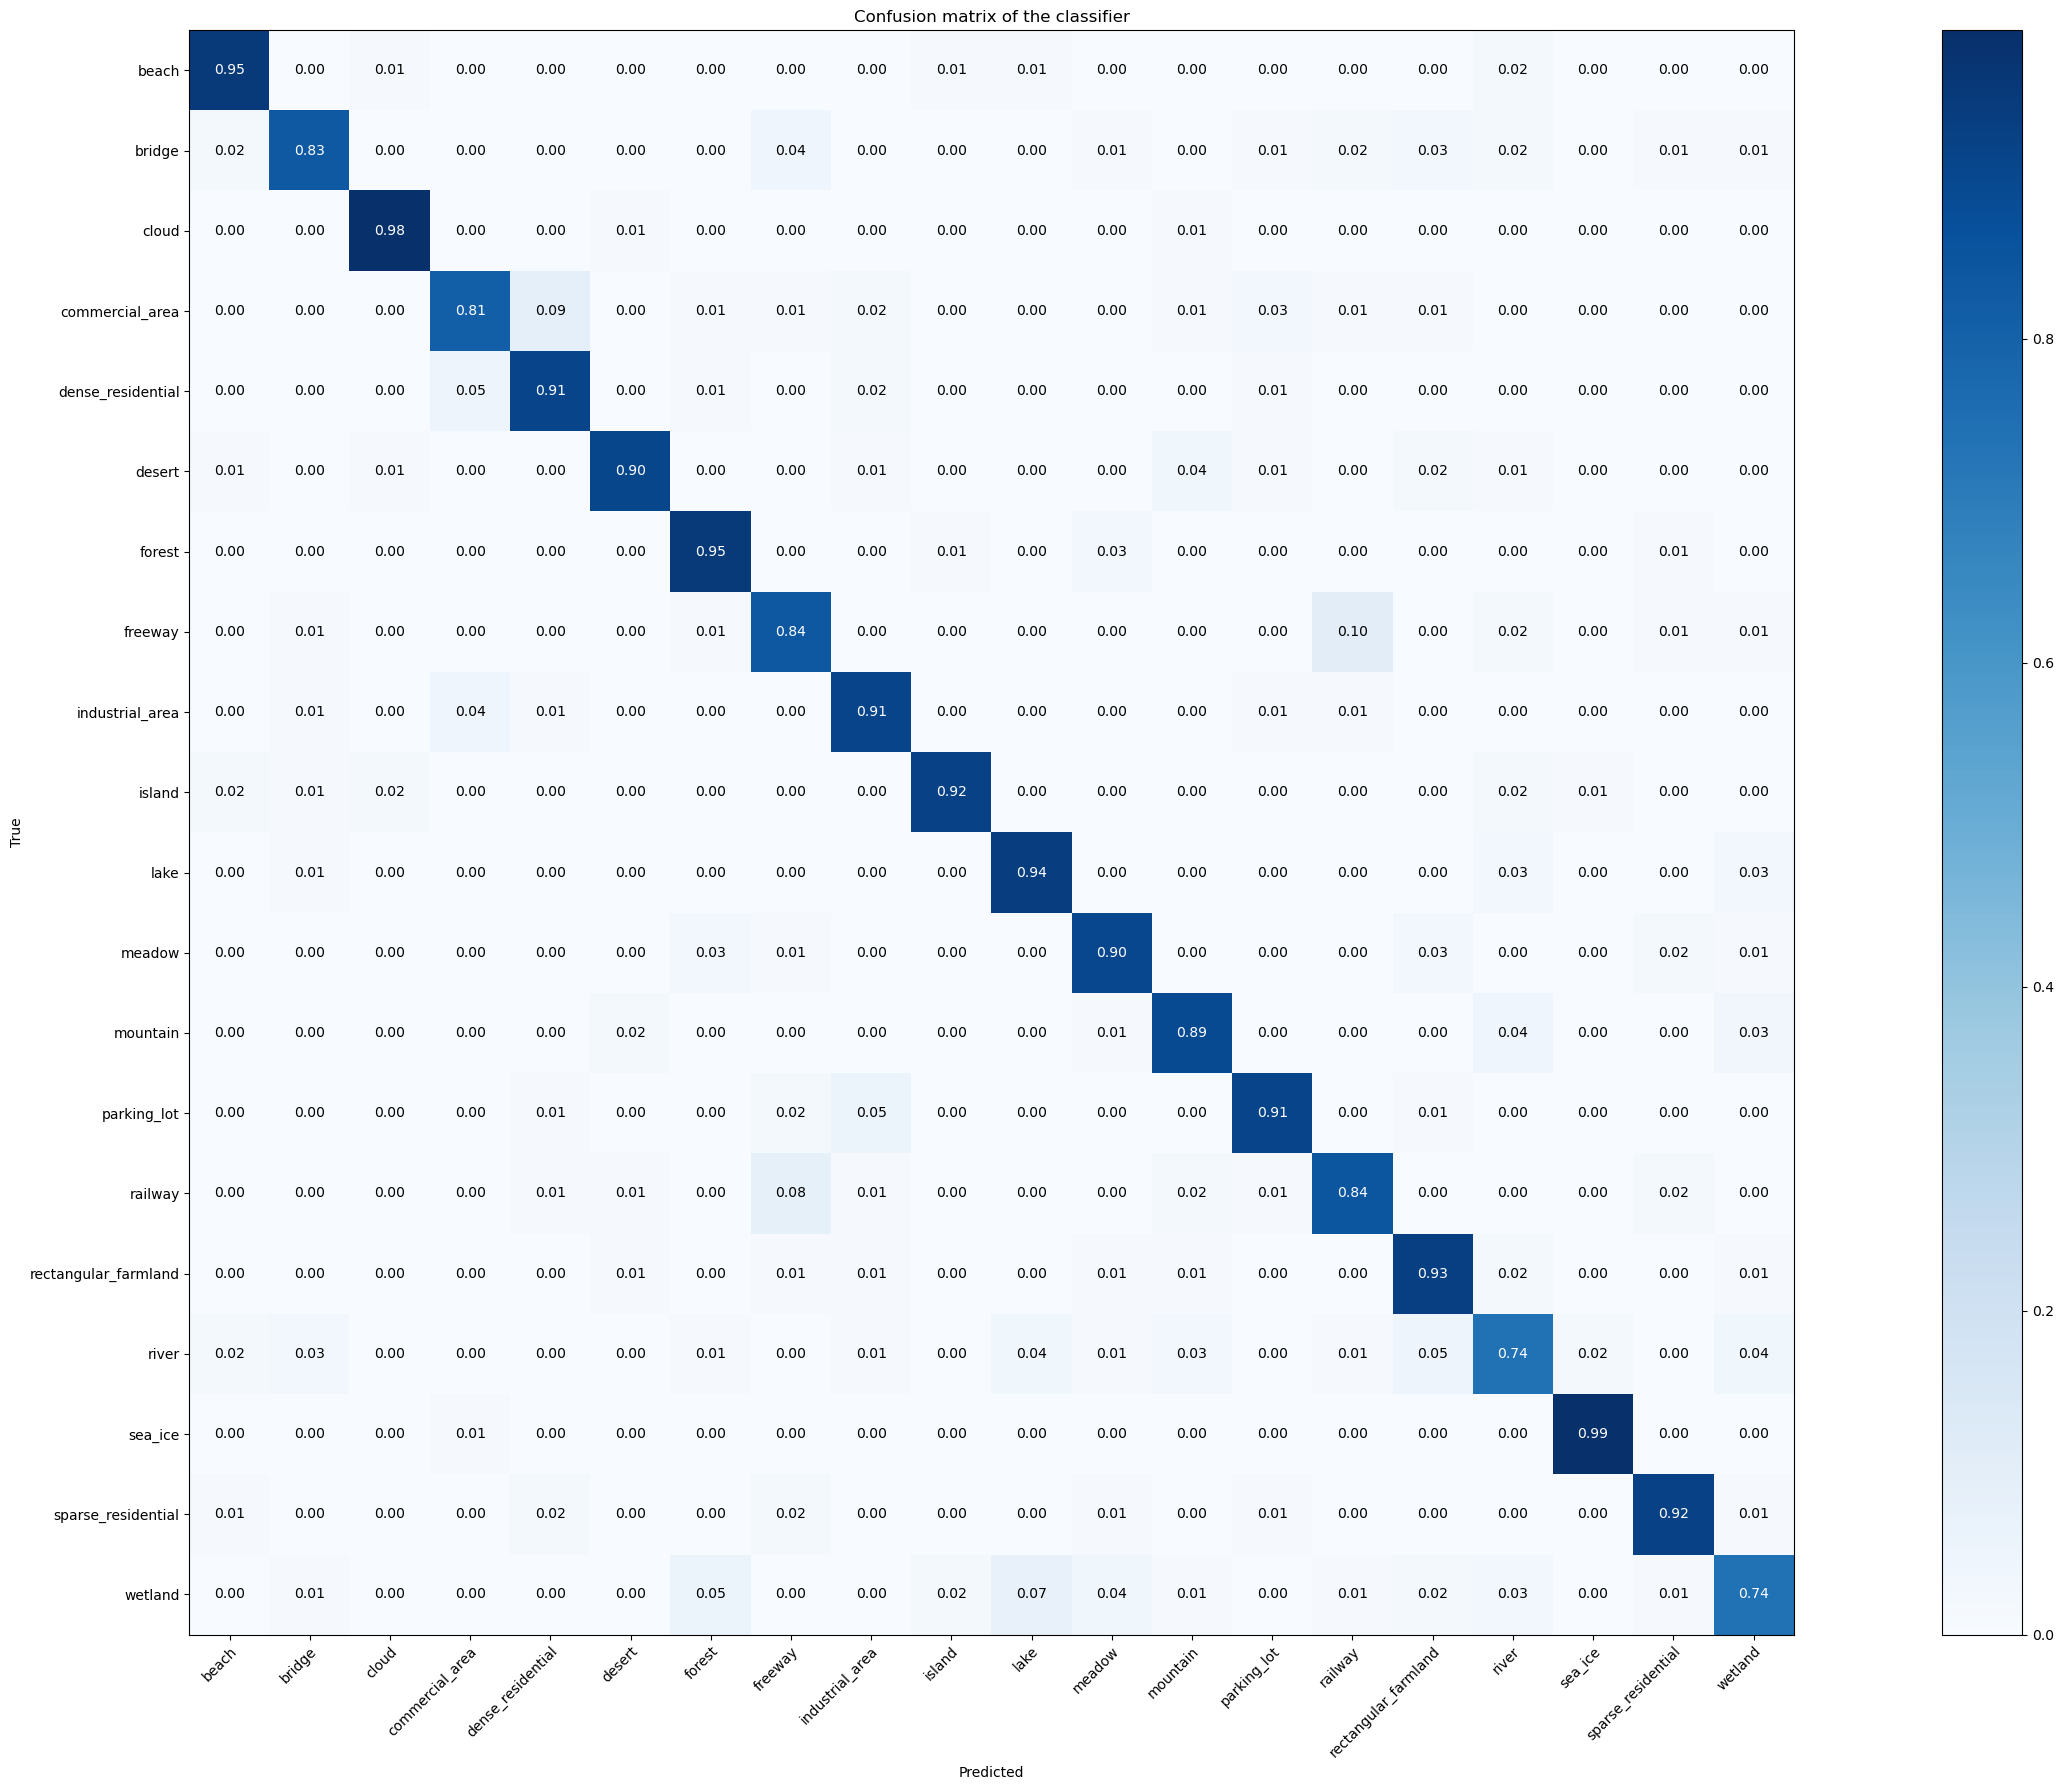

Confusion matrix plot saved as confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [25]:
# import scikit-learn modules
from sklearn.metrics import confusion_matrix

# compute the confusion matrix for the predicted labels and true labels
cm = confusion_matrix(y_true, y_pred, normalize='true')

# create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(30, 18))
im = ax.imshow(cm, cmap='Blues')

# add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set tick labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# rotate the tick labels and set axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# loop over data to create annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, format(cm[i, j], '.2f'),
                       ha="center", va="center", color="white" if cm[i, j] > 0.5 else "black")


# set title and show the plot
ax.set_title("Confusion matrix of the classifier")
fig.tight_layout()
plt.show()

# Save the plot to a file
output_file = "confusion_matrix.png"
plt.savefig(output_file)
print(f"Confusion matrix plot saved as {output_file}")

In [26]:
model.save('model_128.h5')